Get the stock price for Microsoft from yahoo finance and apply the moving over cross over
 trading strategy to the period from the year of 2020 to 2023

In [1]:
from datetime import datetime
import pandas as pd

In [2]:
'''Convert date to the epoch time'''
def date_to_epoch(date):
    return int(date.timestamp())

In [32]:
'''Get the public stock price data for a given ticker'''
def get_stock_price(ticker:str, start_date :datetime = None, end_date :datetime = None) -> pd.DataFrame:
    if not start_date:
        start_date = datetime(2020, 1, 1)
    if not end_date:
        end_date = datetime.now()

    url = f"https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={date_to_epoch(start_date)}&period2={date_to_epoch(end_date)}&interval=1d&events=history&includeAdjustedClose=true"
    df = pd.read_csv(url)
    df = df.set_index("Date")
    df.index = pd.to_datetime(df.index)
    return df
        

In [33]:
df_data = get_stock_price("MSFT")

In [34]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 846 entries, 2019-12-31 to 2023-05-10
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       846 non-null    float64
 1   High       846 non-null    float64
 2   Low        846 non-null    float64
 3   Close      846 non-null    float64
 4   Adj Close  846 non-null    float64
 5   Volume     846 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 46.3 KB


In [35]:
'''Inspect the data'''
df_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-12-31,156.770004,157.770004,156.449997,157.699997,152.930115,18369400
2020-01-02,158.779999,160.729996,158.330002,160.619995,155.761780,22622100
2020-01-03,158.320007,159.949997,158.059998,158.619995,153.822311,21116200
2020-01-06,157.080002,159.100006,156.509995,159.029999,154.219894,20813700
2020-01-07,159.320007,159.669998,157.320007,157.580002,152.813782,21634100


In [7]:
df_data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-05-04,306.239990,307.760010,303.399994,305.410004,305.410004,22519900
2023-05-05,305.720001,311.970001,304.269989,310.649994,310.649994,28181200
2023-05-08,310.130005,310.200012,306.089996,308.649994,308.649994,21318600
2023-05-09,308.000000,310.040009,306.309998,307.000000,307.000000,21340800
2023-05-10,308.619995,313.000000,307.670013,312.309998,312.309998,30058700


In [8]:
df_data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,846.000000,846.000000,846.000000,846.000000,846.000000,8.460000e+02
mean,247.861773,250.659421,245.032198,247.975284,244.652459,3.157430e+07
std,46.223478,46.268578,45.952672,46.161131,46.731585,1.327562e+07
min,137.009995,140.570007,132.520004,135.419998,131.682693,9.200800e+06
25%,214.397495,216.372498,212.502506,214.330005,209.931297,2.287220e+07
50%,247.964996,251.099998,245.834999,248.945000,246.910888,2.833020e+07
75%,284.650010,287.802505,280.572487,284.267494,281.757431,3.540562e+07
max,344.619995,349.670013,342.200012,343.109985,339.075592,9.701270e+07


<Axes: xlabel='Date'>

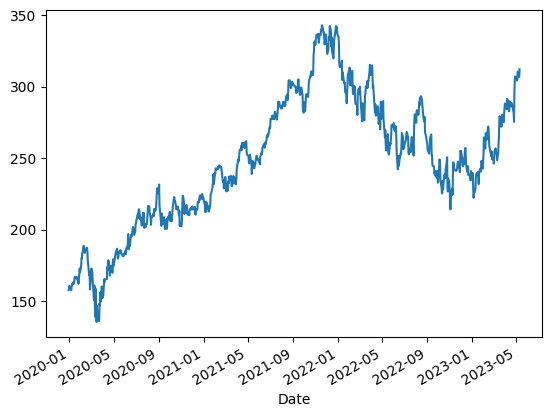

In [25]:
df_data['Close'].plot()

We generate the trading strategy base on the moving average of the stock's closing price.
Aussuming this is a long only fund, when the 5-day moving average crosses above the 20-day moving average, we buy the stock, otherwise don't hold the stock.


In [40]:
short_window = 5
long_window=20

df_data['ShortMA'] = df_data['Close'].rolling(window=short_window).mean()
df_data['LongMA'] = df_data['Close'].rolling(window=long_window).mean()
df_data['ShortMA-1'] = df_data['ShortMA'].shift(1)
df_data['LongMA-1'] = df_data['LongMA'].shift(1)

tc = 0.005  # assuming the transaction cost
df_data['Return'] = df_data['Close'].pct_change()

<Axes: xlabel='Date'>

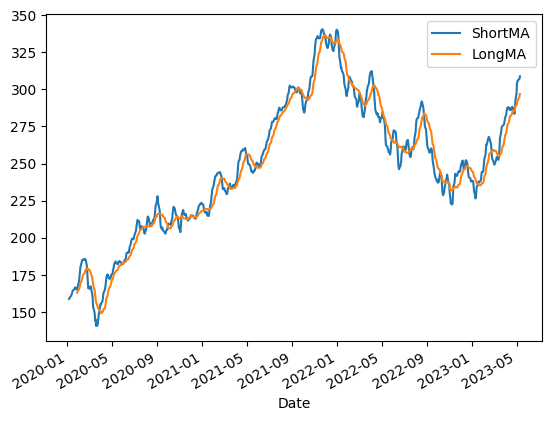

In [41]:
df_data[['ShortMA', 'LongMA']].plot()

In [53]:


df_data['holding'] = 0
df_data.loc[df_data["ShortMA-1"].notna() & df_data["LongMA-1"].notna() & (df_data['ShortMA'] > df_data['LongMA']) & (df_data['ShortMA-1'] < df_data['LongMA-1']), "holding"] = 1
df_data.loc[df_data["ShortMA-1"].notna() & df_data["LongMA-1"].notna() & (df_data['ShortMA'] < df_data['LongMA']) & (df_data['ShortMA-1'] > df_data['LongMA-1']), "holding"] = 0

df_data['holding-1'] = df_data['holding'].shift(1)

In [13]:
'''Calculate the profit and loss, sharp rqatio, and trading days'''
df_data['pnl'] = df_data['Return'] * df_data['holding-1'] - tc * abs(df_data['holding'] - df_data['holding-1'])
sharp_ratio = df_data['pnl'].mean() / df_data['pnl'].std() * (252 ** 0.5)
trading_days = df_data['holding'].sum()


In [14]:
sharp_ratio

-0.8488583229404678

In [15]:
trading_days

393

In [16]:
'''Define a function to calculate the CLHL strategy performance for a given threshold and transaction cost'''
def calculate_clhl(clhl_threshold, data, tc=0.0005):
    df_data = data.copy()
    df_data['CLHL'] = (df_data['Close'] - df_data['Low']) / (df_data['High'] - df_data['Low'])
    df_data['Return'] = df_data['Close'].pct_change()

    df_data['holding'] = df_data['CLHL'] < clhl_threshold
    df_data['holding'] = df_data['holding'].astype(int)
    df_data['holding-1'] = df_data['holding'].shift(1)
    df_data['signal'] = df_data['holding'] - df_data['holding-1']

    df_data['pnl'] = df_data['Return'] * df_data['holding-1'] - tc * abs(df_data['holding'] - df_data['holding-1'])
    df_data['pnl_cum'] = df_data['pnl'].cumsum()
    df_data['ret_cum'] = df_data['Return'].cumsum()
    sharp_ratio = df_data['pnl'].mean() / df_data['pnl'].std() * (252 ** 0.5)
    trading_days = df_data['holding'].sum()

    return sharp_ratio, trading_days, df_data

In [17]:
'''Calcuate CLHL threshold and the corresponding sharp ratio and trading days iteratively'''
clhl_thresholds = [0.01 * i for i in range(1, 100)]
sharp_ratios = []
trading_days = []

for clhl_threshold in clhl_thresholds:
    sharp_ratio, trading_day, df_new = calculate_clhl(clhl_threshold, df_data)
    sharp_ratios.append(sharp_ratio)
    trading_days.append(trading_day)


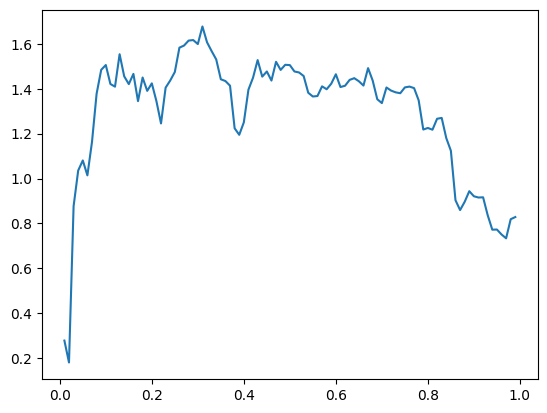

In [18]:
import matplotlib.pyplot as plt
plt.plot(clhl_thresholds, sharp_ratios, label='sharp ratio')

In [19]:
'''Combine the clhl thresholds, sharp ratio, trading days to dataframe'''
df_result = pd.DataFrame({'clhl_threshold': clhl_thresholds, 'sharp_ratio': sharp_ratios, 'trading_days': trading_days})

In [20]:
df_result.head()

,clhl_threshold,sharp_ratio,trading_days
0,0.01,0.277404,4
1,0.02,0.179778,12
2,0.03,0.876437,21
3,0.04,1.035589,30
4,0.05,1.080480,50


In [21]:
'''Sort the df_result by sharp_ratio'''
df_result = df_result.sort_values(by='sharp_ratio', ascending=False)

In [22]:
'''Find the clhl_threshold with highest sharp_ratio'''
df_result

,clhl_threshold,sharp_ratio,trading_days
30,0.31,1.677813,263
28,0.29,1.617263,252
27,0.28,1.614915,248
31,0.32,1.607468,271
29,0.30,1.599384,256
...,...,...,...
93,0.94,0.771860,737
95,0.96,0.750630,774
96,0.97,0.733343,795
0,0.01,0.277404,4


In [23]:
'''Pick 0.31 as the best clhl_threshold'''
df_best  = calculate_clhl(0.31, df_data)

<Axes: xlabel='Date'>

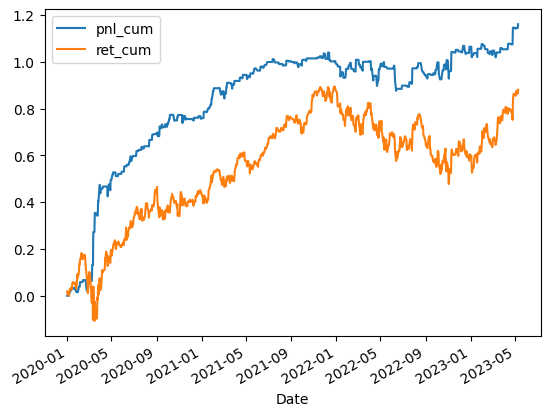

In [24]:
'''Compare the active trading return vs buy and hold return'''
df_best[2][['pnl_cum', 'ret_cum']].plot()